In [2]:
!git clone https://github.com/bao18/open_earth_map.git './OEM/' # <= change path where you save code

Cloning into './OEM'...
remote: Enumerating objects: 292, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 292 (delta 31), reused 46 (delta 18), pack-reused 233
Receiving objects: 100% (292/292), 9.46 MiB | 14.17 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [19]:
import gdown
import zipfile

url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U"
output = "./dataset/OpenEathMap_Mini.zip" # <= change path where you save data
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U
To: /home/fontanger/remote_sensing/project/dataset/OpenEathMap_Mini.zip
100%|██████████| 2.52G/2.52G [00:27<00:00, 92.3MB/s]


In [29]:
!unzip -q "./dataset/OpenEathMap_Mini.zip" # <= change path where you save data

In [30]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import sys
sys.path.append('./OEM') # <= change path where you save code
import oem

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [33]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "./dataset/OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 8
NUM_EPOCHS = 50
DEVICE = "cuda"
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [34]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


In [35]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

In [36]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns, # train data
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns, # val data
    n_classes=N_CLASSES,
    augm=val_augm,
)

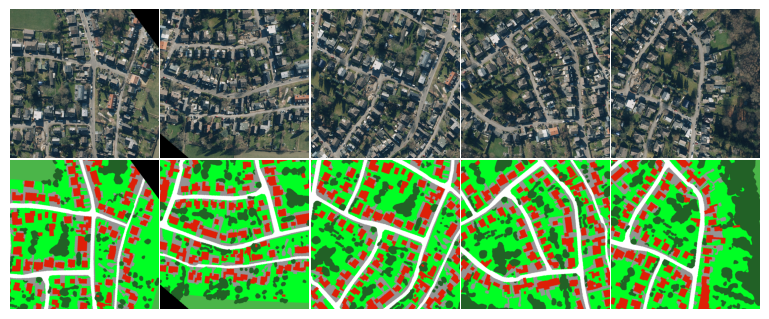

In [37]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [38]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

In [39]:
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()

In [40]:
config_name = f"""
  Unet_optimizer={type(optimizer).__name__}_\
  loss_fctn={type(criterion).__name__}_\
  batch_size={BATCH_SIZE}_\
  light_augmentation_\
  image_size={IMG_SIZE}_\
  LR={LR}_\
  NUM_EPOCHS={NUM_EPOCHS}\""""
config_name

'\n  Unet_optimizer=Adam_  loss_fctn=JaccardLoss_  batch_size=4_  light_augmentation_  image_size=512_  LR=0.0001_  NUM_EPOCHS=50"'

In [41]:
start = time.time()

val_loss_history = []
train_loss_history = []
val_score_history = [] 
train_score_history = []

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    train_loss_history.append(train_logs["Loss"])
    train_score_history.append(train_logs["Score"])

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )

    val_loss_history.append(valid_logs["Loss"])
    val_score_history.append(valid_logs["Score"])

    print(train_loss_history)
    print(val_loss_history)


    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 23/23 [00:04<00:00,  5.75it/s, Loss=7.01, Score=0.0685]


[7.118537200580944]
[7.008750086245329]
model saved

Epoch: 2


Valid: 100%|██████████| 23/23 [00:04<00:00,  5.70it/s, Loss=6.45, Score=0.117]


[7.118537200580944, 6.695259886076956]
[7.008750086245329, 6.454077223072881]
model saved

Epoch: 3


Valid: 100%|██████████| 23/23 [00:03<00:00,  5.79it/s, Loss=6.36, Score=0.126]


[7.118537200580944, 6.695259886076956, 6.493874607664166]
[7.008750086245329, 6.454077223072881, 6.363656583039657]
model saved

Epoch: 4


Train:  81%|████████  | 134/165 [00:46<00:10,  2.96it/s, Loss=6.42, Score=0.122]

In [1]:
train_loss_history

NameError: name 'train_loss_history' is not defined

In [14]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

NameError: name 'Path' is not defined

In [15]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

NameError: name 'oem' is not defined

In [16]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)


NameError: name 'oem' is not defined

In [17]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

NameError: name 'np' is not defined

In [ ]:
import math
from PIL import Image

PR_DIR = "/content/drive/My Drive/Colab/OEM/png" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input) 
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)